# Gaussian process regression

In [260]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

### A Get the data

In [264]:
rawdata='C:\\Python34\\datasets\\matkaaika_V1.csv'
df = pd.read_csv(rawdata)
nSamples=len(df)

### A1 Examine the data

In [265]:
print('Shape of df:', df.shape)
#print(df.head())
print(df.describe())


Shape of df: (35, 9)
         0        min8      kesto  viikonpaiva      lunta  huono keli
count  0.0   31.000000  33.000000    33.000000  35.000000   33.000000
mean   NaN   54.064516  46.515152     3.303030   0.400000    0.030303
std    NaN   45.819163   5.362609     1.686061   0.811679    0.174078
min    NaN -120.000000  42.000000     1.000000   0.000000    0.000000
25%    NaN   37.500000  43.000000     2.000000   0.000000    0.000000
50%    NaN   55.000000  44.000000     3.000000   0.000000    0.000000
75%    NaN   75.500000  47.000000     4.000000   1.000000    0.000000
max    NaN  160.000000  61.000000     7.000000   4.000000    1.000000


B, C Clean and prepare the data

In [266]:
# Delete unnecessary columns
col_to_delete=['0', 'lunta', 'huono keli']
df=df.drop(col_to_delete, 1)
df.describe()

,min8,kesto,viikonpaiva
count,31.000000,33.000000,33.000000
mean,54.064516,46.515152,3.303030
std,45.819163,5.362609,1.686061
min,-120.000000,42.000000,1.000000
25%,37.500000,43.000000,2.000000
50%,55.000000,44.000000,3.000000
75%,75.500000,47.000000,4.000000
max,160.000000,61.000000,7.000000


In [267]:
# Show which columns have missing values
missValues=df.apply(lambda x: sum(x.isnull()),axis=0)
print('Missing values in columns:\n',missValues) 

Missing values in columns:
 lahtoaika      0
tuloaika       2
min8           4
kesto          2
viikonpaiva    2
paiva          4
dtype: int64


In [268]:
# Delete rows with missing values
df = df.dropna()
df.describe()

,min8,kesto,viikonpaiva
count,30.00000,30.000000,30.000000
mean,54.80000,46.733333,3.233333
std,46.41596,5.576634,1.735697
min,-120.00000,42.000000,1.000000
25%,38.00000,43.250000,2.000000
50%,55.50000,44.000000,3.000000
75%,76.25000,47.750000,4.000000
max,160.00000,61.000000,7.000000


### D Select the features and labels

In [277]:
X=df['min8'].values
X=X.reshape(-1, 1)
y=df['kesto'].values
print(len(X), len(y))
print(type(X))


30 30
<class 'numpy.ndarray'>


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001899F9B0>]], dtype=object)

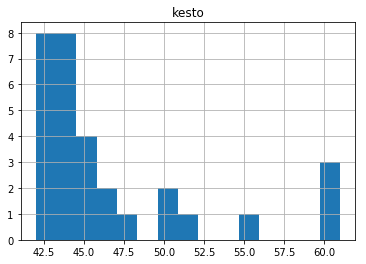

In [279]:
# Histogram of y
df.hist('kesto', bins=15)

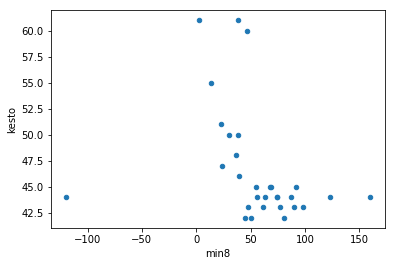

In [280]:
# Scatter plot
df.plot.scatter('min8', 'kesto')

### E Select the training and test set

## Gaussian process

### Function to plot GPR results

In [281]:
def plotGPRresults(gp, X, y, xtest=0, ytest_true=0, dy=0):
    """
    Plot results for the gp model (one-dimensional data X)
    dy = error in the training data
    X, y, dy = training data
    
    xtest = test data x-points
    ytest_true = true function at xtest-points
    """
    
    # Calculate the predictions
    y_pred, sigma = gp.predict(xtest, return_std=True)


    plt.figure()
        
    # Plot the predictions    
    plt.plot(xtest, y_pred, 'b-', label='prediction +_ 2sigma')
    plt.plot(xtest, y_pred - 2*sigma, 'b:')
    plt.plot(xtest, y_pred + 2*sigma, 'b:')


    # Plot the training data, with errorbar dy if it's available
    if(np.sum(dy) != 0):       
        plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'observations')
    else:
        plt.plot(X, y, 'r.', markersize=10, label='training data')


    # Plot the true function if available
    if(np.sum(ytest_true) != 0):  
        plt.plot(xtest, ytest_true, 'r:', label='true function')

    # Optionally plot also a 'baseline'
    # plt.plot(xtest, np.min(y)*np.ones(len(xtest)) , 'k--')
    
    plt.xlabel('X')
    plt.ylabel('y')
    plt.ylim(np.min(y)*0.5, np.max(y)*1.5)
    plt.legend()
    plt.show()



### F Train the model

In [282]:
# Gaussian process
kernel = C(1.0) * RBF(1, (1e-1, 1e3)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+2))
alpha = 0.1
gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)

In [283]:
# Fit the hyperparameters
gp.fit(X, y)
print('\nOptimized kernel:', gp.kernel_)
print('Log marginal likelihood:', gp.log_marginal_likelihood_value_)


Optimized kernel: 39.5**2 * RBF(length_scale=124) + WhiteKernel(noise_level=17.9)
Log marginal likelihood: -95.4506286889


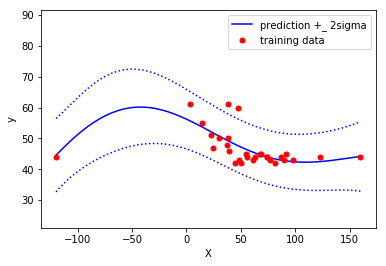

In [284]:
# Plot for test data points in a range
xtest = np.linspace(start=-120, stop=160, num=50).reshape(-1, 1)
plotGPRresults(gp, X, y, xtest)

### G Test the model

In [275]:
xtest=np.atleast_2d([-40, 0, 50, 120]).T
y_pred, sigma = gp.predict(xtest, return_std=True)
for i, (a, b, c) in enumerate(zip(xtest, y_pred, sigma)):
    print("x, y, +_ 2sigma", a, b, 2*c)

x, y, +_ 2sigma [-40] 60.1344874457 11.9924754341
x, y, +_ 2sigma [0] 56.2203713229 9.65191903691
x, y, +_ 2sigma [50] 47.1819626899 8.66137512171
x, y, +_ 2sigma [120] 42.3964272345 9.27915548965
